# CNOD Sequence Illustration
This file illustrates how the CNOD sequence works, step by step.

### Imports
If not working check the files under analyze -> fit_func. Check that the path directory is correct

Files to check: (exp_decay_sine.py, exp_decay_doubleSine.py, exp_decay_to_zero_sine_withHeating.py, exp_decay_to_zero_sine) 

In [23]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import gaussian, square
from System import *
import qutip as qt
from Visualization import *

import os, sys
p_current = os.getcwd() #当前文件所在的文件夹路径：第一级父路径
p_parent = os.path.abspath(os.path.join(p_current,os.pardir)) # 当前文件所在的文件夹路径的父文件夹路径： 第二级父路径  http://www.moonapi.com/news/1923.html
sys.path.insert(1,p_parent) 
import analyze.fit as fit

from scipy.integrate import simpson
from numpy import trapz

# Uncomment the two lines below to use interactive plots
# %matplotlib widget
# plt.ion()

### Choose figures' resolution

In [24]:
npts = 200 # number of points in Wigner function plots
max_alpha = 6.0 # alpha max limit in Wigner function plots
dpi = 300 # dpi for saved pictures

### Define CNOD Pulse Shape

##### Example: Anti-Symmetric Gaussian pulse
##### $~~ H_d/\hbar = A \ e^{-\frac{1}{2\sigma^2}} \ \sin(\delta t) \ e^{-i(\chi - \omega_c)t} = \frac{A e^{-\frac{1}{2\sigma^2}} }{2i}[e^{i(-\chi + \delta + \omega_c)t} - e^{i(-\chi - \delta + \omega_c)t}] $


In [25]:
def create_padded_gaussian(start, sigma, multiplier, tfinal, timestep = 1, is_cut_tail = True):
    before_zeros = np.zeros(round(start/timestep))
    gauss = gaussian(round((sigma*multiplier)/timestep), sigma/timestep)
    if (not is_cut_tail): gauss = gauss-np.min(gauss)
    after_zeros  = np.zeros(round((tfinal-start-sigma*multiplier)/timestep))
    padded_gauss = np.append(np.append(before_zeros, gauss), after_zeros)
    return padded_gauss

def create_antisym_gaussian(alpha, start, sigma, multiplier, detuning, tfinal, omega_shift = 0, timestep = 1, is_cut_tail = True):
    gauss = create_padded_gaussian(start, sigma, multiplier, tfinal, timestep, is_cut_tail)
    times = np.linspace(0, tfinal-timestep, int(tfinal/timestep))
    waveform = np.sin((times-sigma*multiplier/2) * detuning) * alpha * gauss / sigma / np.sqrt(2*np.pi) #/ timestep
    pulse = waveform * np.exp(-1j*omega_shift*(times-start-sigma*multiplier/2))
    # Uncomment the lines below to see how the different pulse components look like 
    # fig, ax = plt.subplots(3, 1)#, figsize=(14, 8)) # Create a 2-plot figure 
    # ax[0].plot(times, gauss)
    # ax[1].plot(times, waveform.real)
    # ax[1].plot(times, waveform.imag)
    # ax[2].plot(times, pulse.real)
    # ax[2].plot(times, pulse.imag)
    return pulse

def create_antisym_square(alpha, start, length, tfinal, omega_shift = 0, timestep = 1):
    times = np.linspace(0, tfinal-timestep, int(tfinal/timestep))
    before_zeros = np.zeros(round(start/timestep))
    after_zeros  = np.zeros(round((tfinal-start-length)/timestep))
    square_time = np.arange(length)
    square = alpha * (-np.sign(square_time-length/2))
    waveform = np.append(np.append(before_zeros, square), after_zeros)
    return waveform * np.exp(-1j*omega_shift*(times-start-length/2))

### Choose System and Pulse Parameters

In [26]:
wCg = 0 #6 * 2*np.pi # Cavity Frequency in GHz
chi =  ((CHI * 1e-3) + wCg) # GHz
omega_shift = chi

H = chi * a.dag() * a * proj_e 

# Pulse parameters
is_square = False # Choose between gaussian or square pulse
is_cut_tail_antisym = True # Choose between smooth pulse or cut tail pulse

Total_gate_time = int(round(292.81,0))*3//4 + 1 # Choose Total Gate Time
sigma = Total_gate_time/4 
detuning = -chi/1e6 # Choose detuning 
multiplier = 2 # Choose multiplier for gaussian pulse

# Amplitude of the pulse
alpha = 4.0  
disp05amp = 0.03 if is_square else (21779713.7523335408 if is_cut_tail_antisym else 117500000) #calibrate for each set of pulse parameters by setting alpha to 1
alpha_amp = alpha * disp05amp

# Total Gate period
condisp_start_time = 0
condisp_stop_time = sigma * multiplier

timestep = 1
tfinal= condisp_stop_time
times = np.linspace(0, tfinal, int(tfinal / timestep))

# opts = Options(store_final_state=True, nsteps = len(times) * 1, max_step = 0.01)
opts = Options(store_final_state=True)

print("wC:", wCg/2/np.pi, "GHz")
print("Chi:", chi/2/np.pi, "GHz =", (chi)/2/np.pi*(10**6), "KHz")
print("Detuning:", detuning/2/np.pi*(10**6), "* 2π kHz")
print("Chosen timestep:", timestep)
print("Total gate time:", Total_gate_time, "ns")
print("Time for one asymmetric pulse:", Total_gate_time/2, "ns")
print("Pulse choice:", "" if is_square else ("Rough" if is_cut_tail_antisym else "Smooth"), "Square" if is_square else "Anti-symmetric Gaussian")

wC: 0.0 GHz
Chi: 0.001 GHz = 1000.0 KHz
Detuning: -0.001 * 2π kHz
Chosen timestep: 1
Total gate time: 220 ns
Time for one asymmetric pulse: 110.0 ns
Pulse choice: Rough Anti-symmetric Gaussian


### Define Projectors, Loss and Expectation parameters

In [27]:
proj_e_a = qt.tensor(basis(2,1)*basis(2,1).dag(), destroy(N)) # |e><e| x a
proj_g_a = qt.tensor(basis(2,0)*basis(2,0).dag(), destroy(N)) # |g><g| x a
Number = tensor(qeye(2), destroy(N).dag()*destroy(N))  # I x a†a

conv = 1e3 # Unit conversion factor

c_ops = [] # No Loss
# c_ops = calc_loss(np.inf, np.inf, np.inf, np.inf) # No Loss
# c_ops = calc_loss(260*conv, 260*conv, 18*conv, 7*conv) # With Loss

e_ops = [2 *  proj_e_a, 2 * proj_g_a, Number] # Expectation values. The 2 factor is for normalisation if starting with superposition state |g> + |e>.
# e_ops = [proj_e_a, proj_g_a ] # for g or e state

### Create the pulse

In [28]:
if is_square:
    asym_pulse_alpha = create_antisym_square(alpha = -alpha_amp,
                              start = condisp_start_time,
                              length = tfinal,
                              omega_shift = omega_shift,
                              tfinal = tfinal, timestep = timestep)
else:
    asym_pulse_alpha = create_antisym_gaussian(alpha = -alpha_amp,
                          start = condisp_start_time,
                          sigma = sigma,
                          multiplier = multiplier,
                          detuning = detuning,
                          omega_shift = omega_shift,
                          tfinal = tfinal, 
                          timestep = timestep, 
                          is_cut_tail = is_cut_tail_antisym)

### Plot the Pulse in time domain and its FFT in frequency domain

PARAMETERS:
wC: 0.0 * 2π GHz
Chi: 1000.0 * 2π kHz
Detuning: -0.001 * 2π kHz
Total gate time: 220 ns
Pulse choice: Rough Anti-symmetric Gaussian
Max waveform amplitude: real = 0.12613863605416614 , imag = 0.04527399874762872
 
Power: 5.029735860939069
Max voltage: 0.1336549469124812


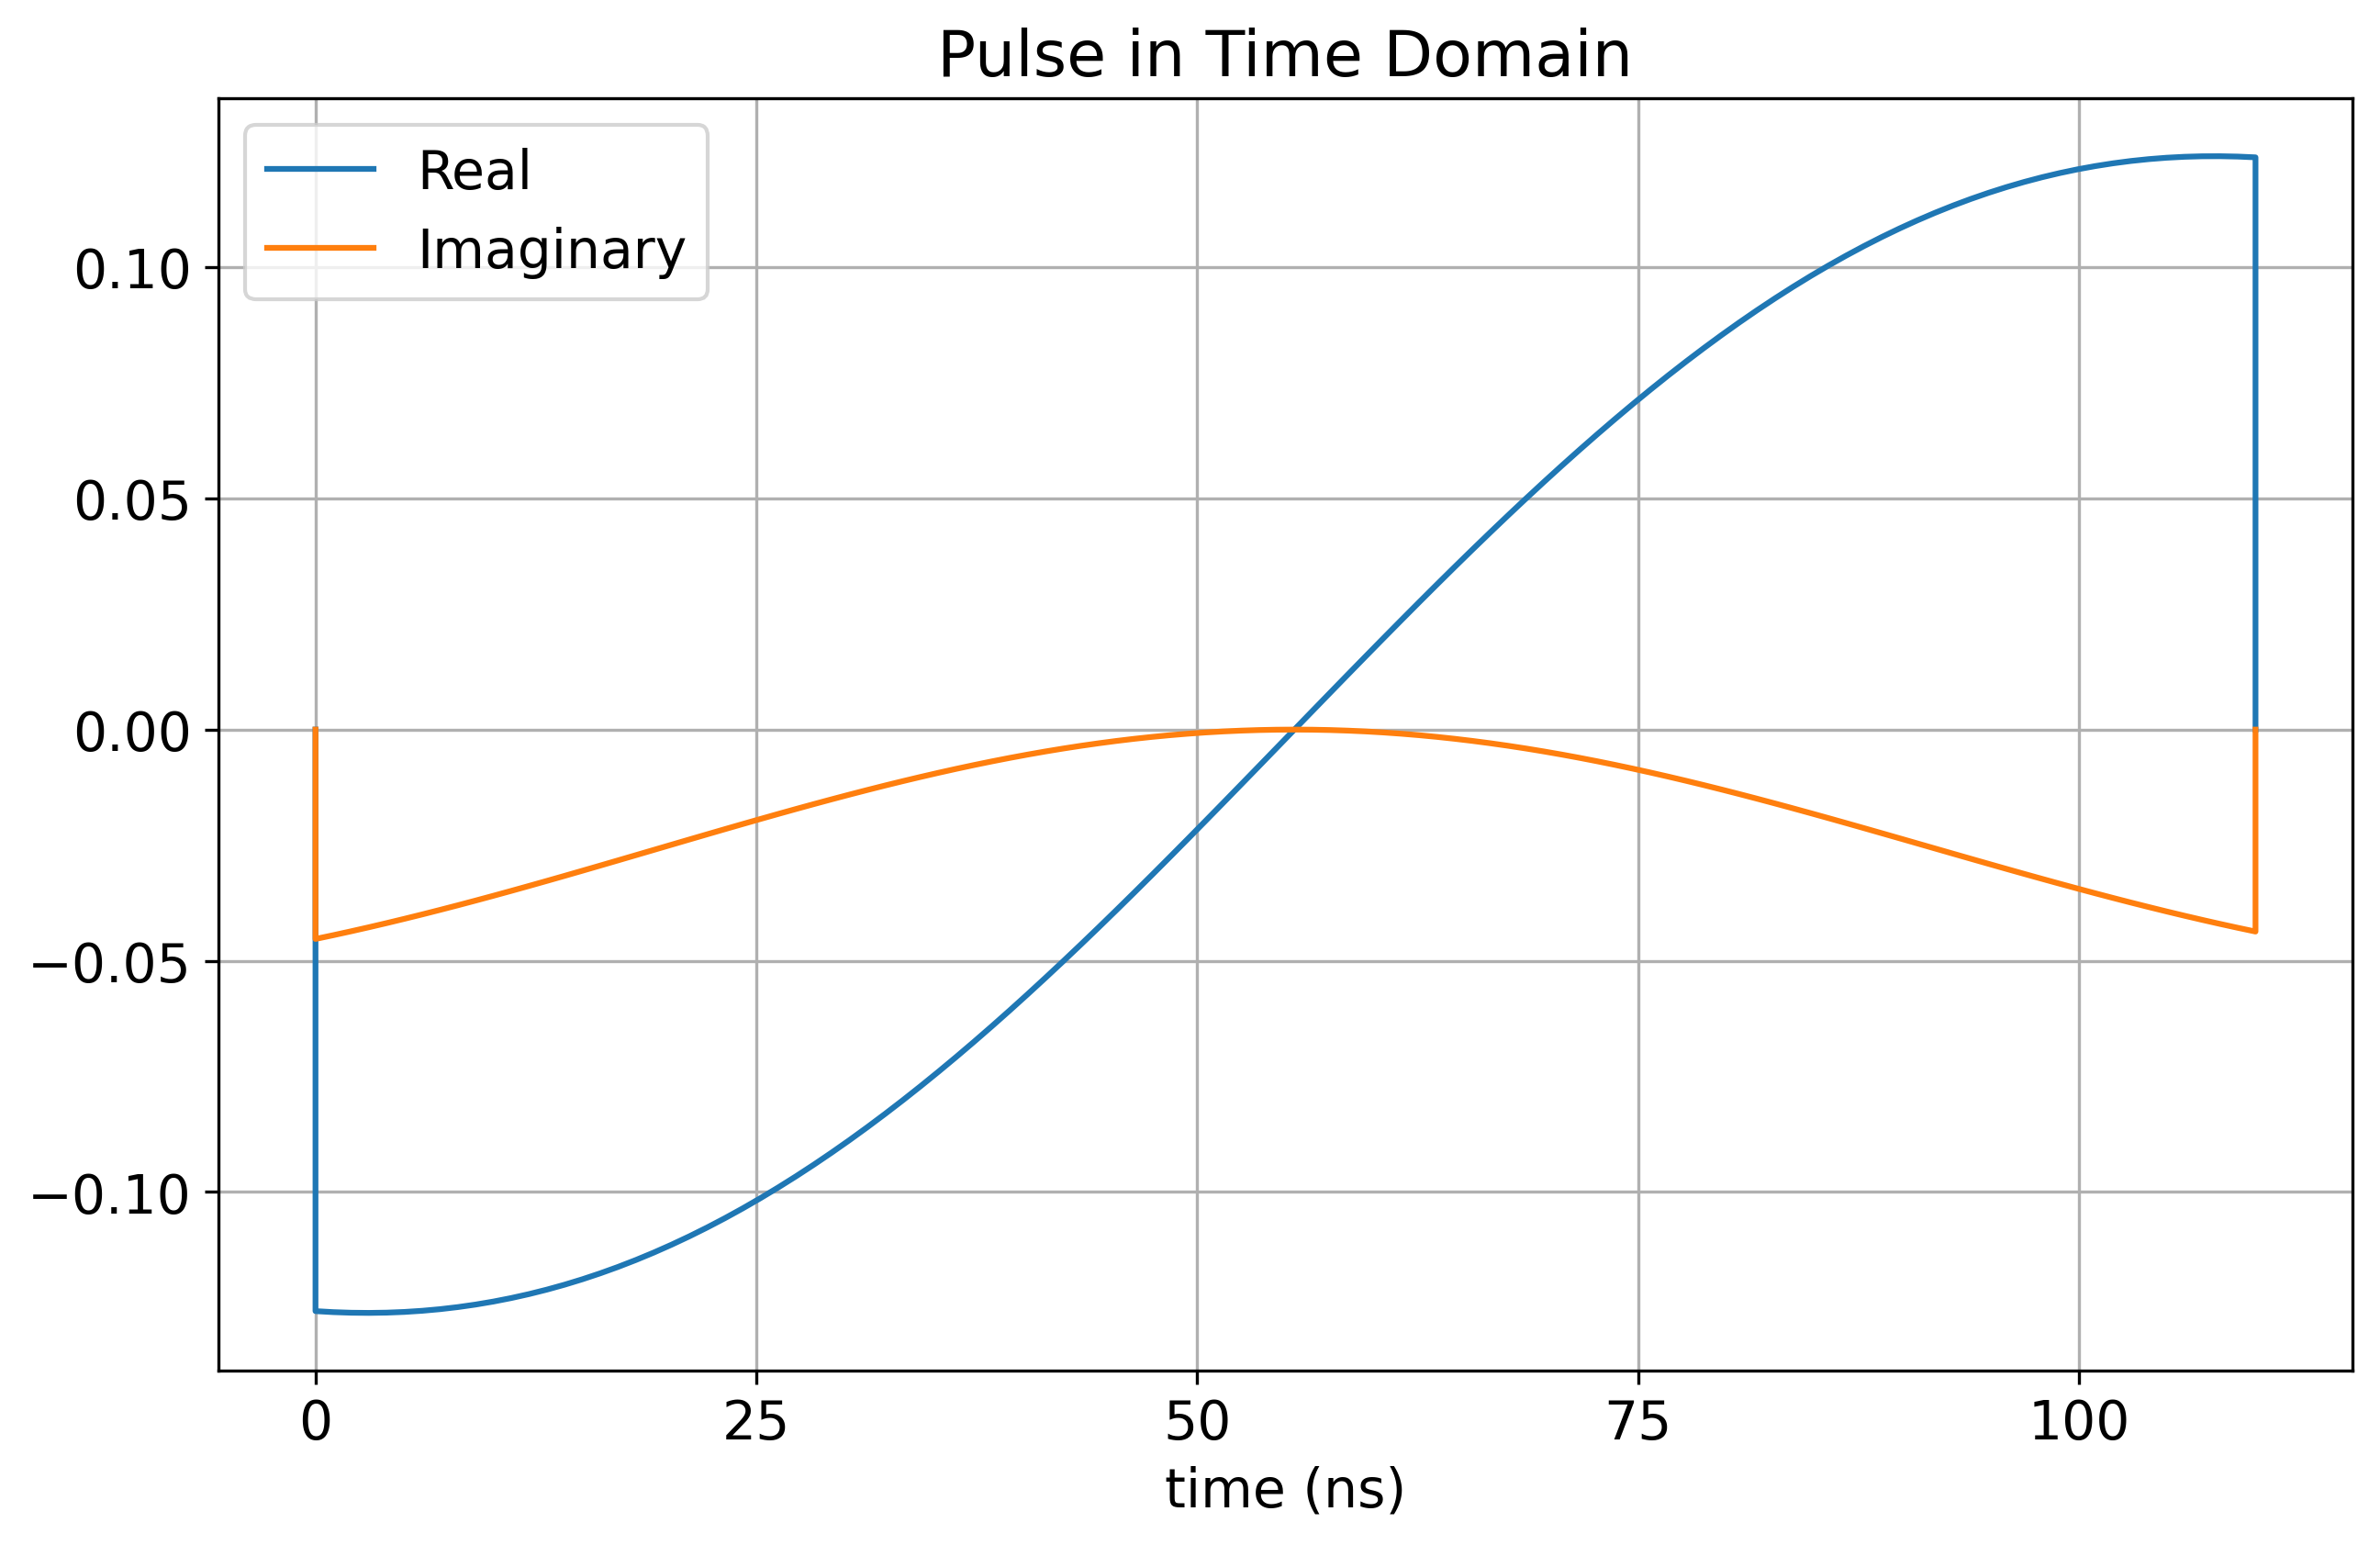

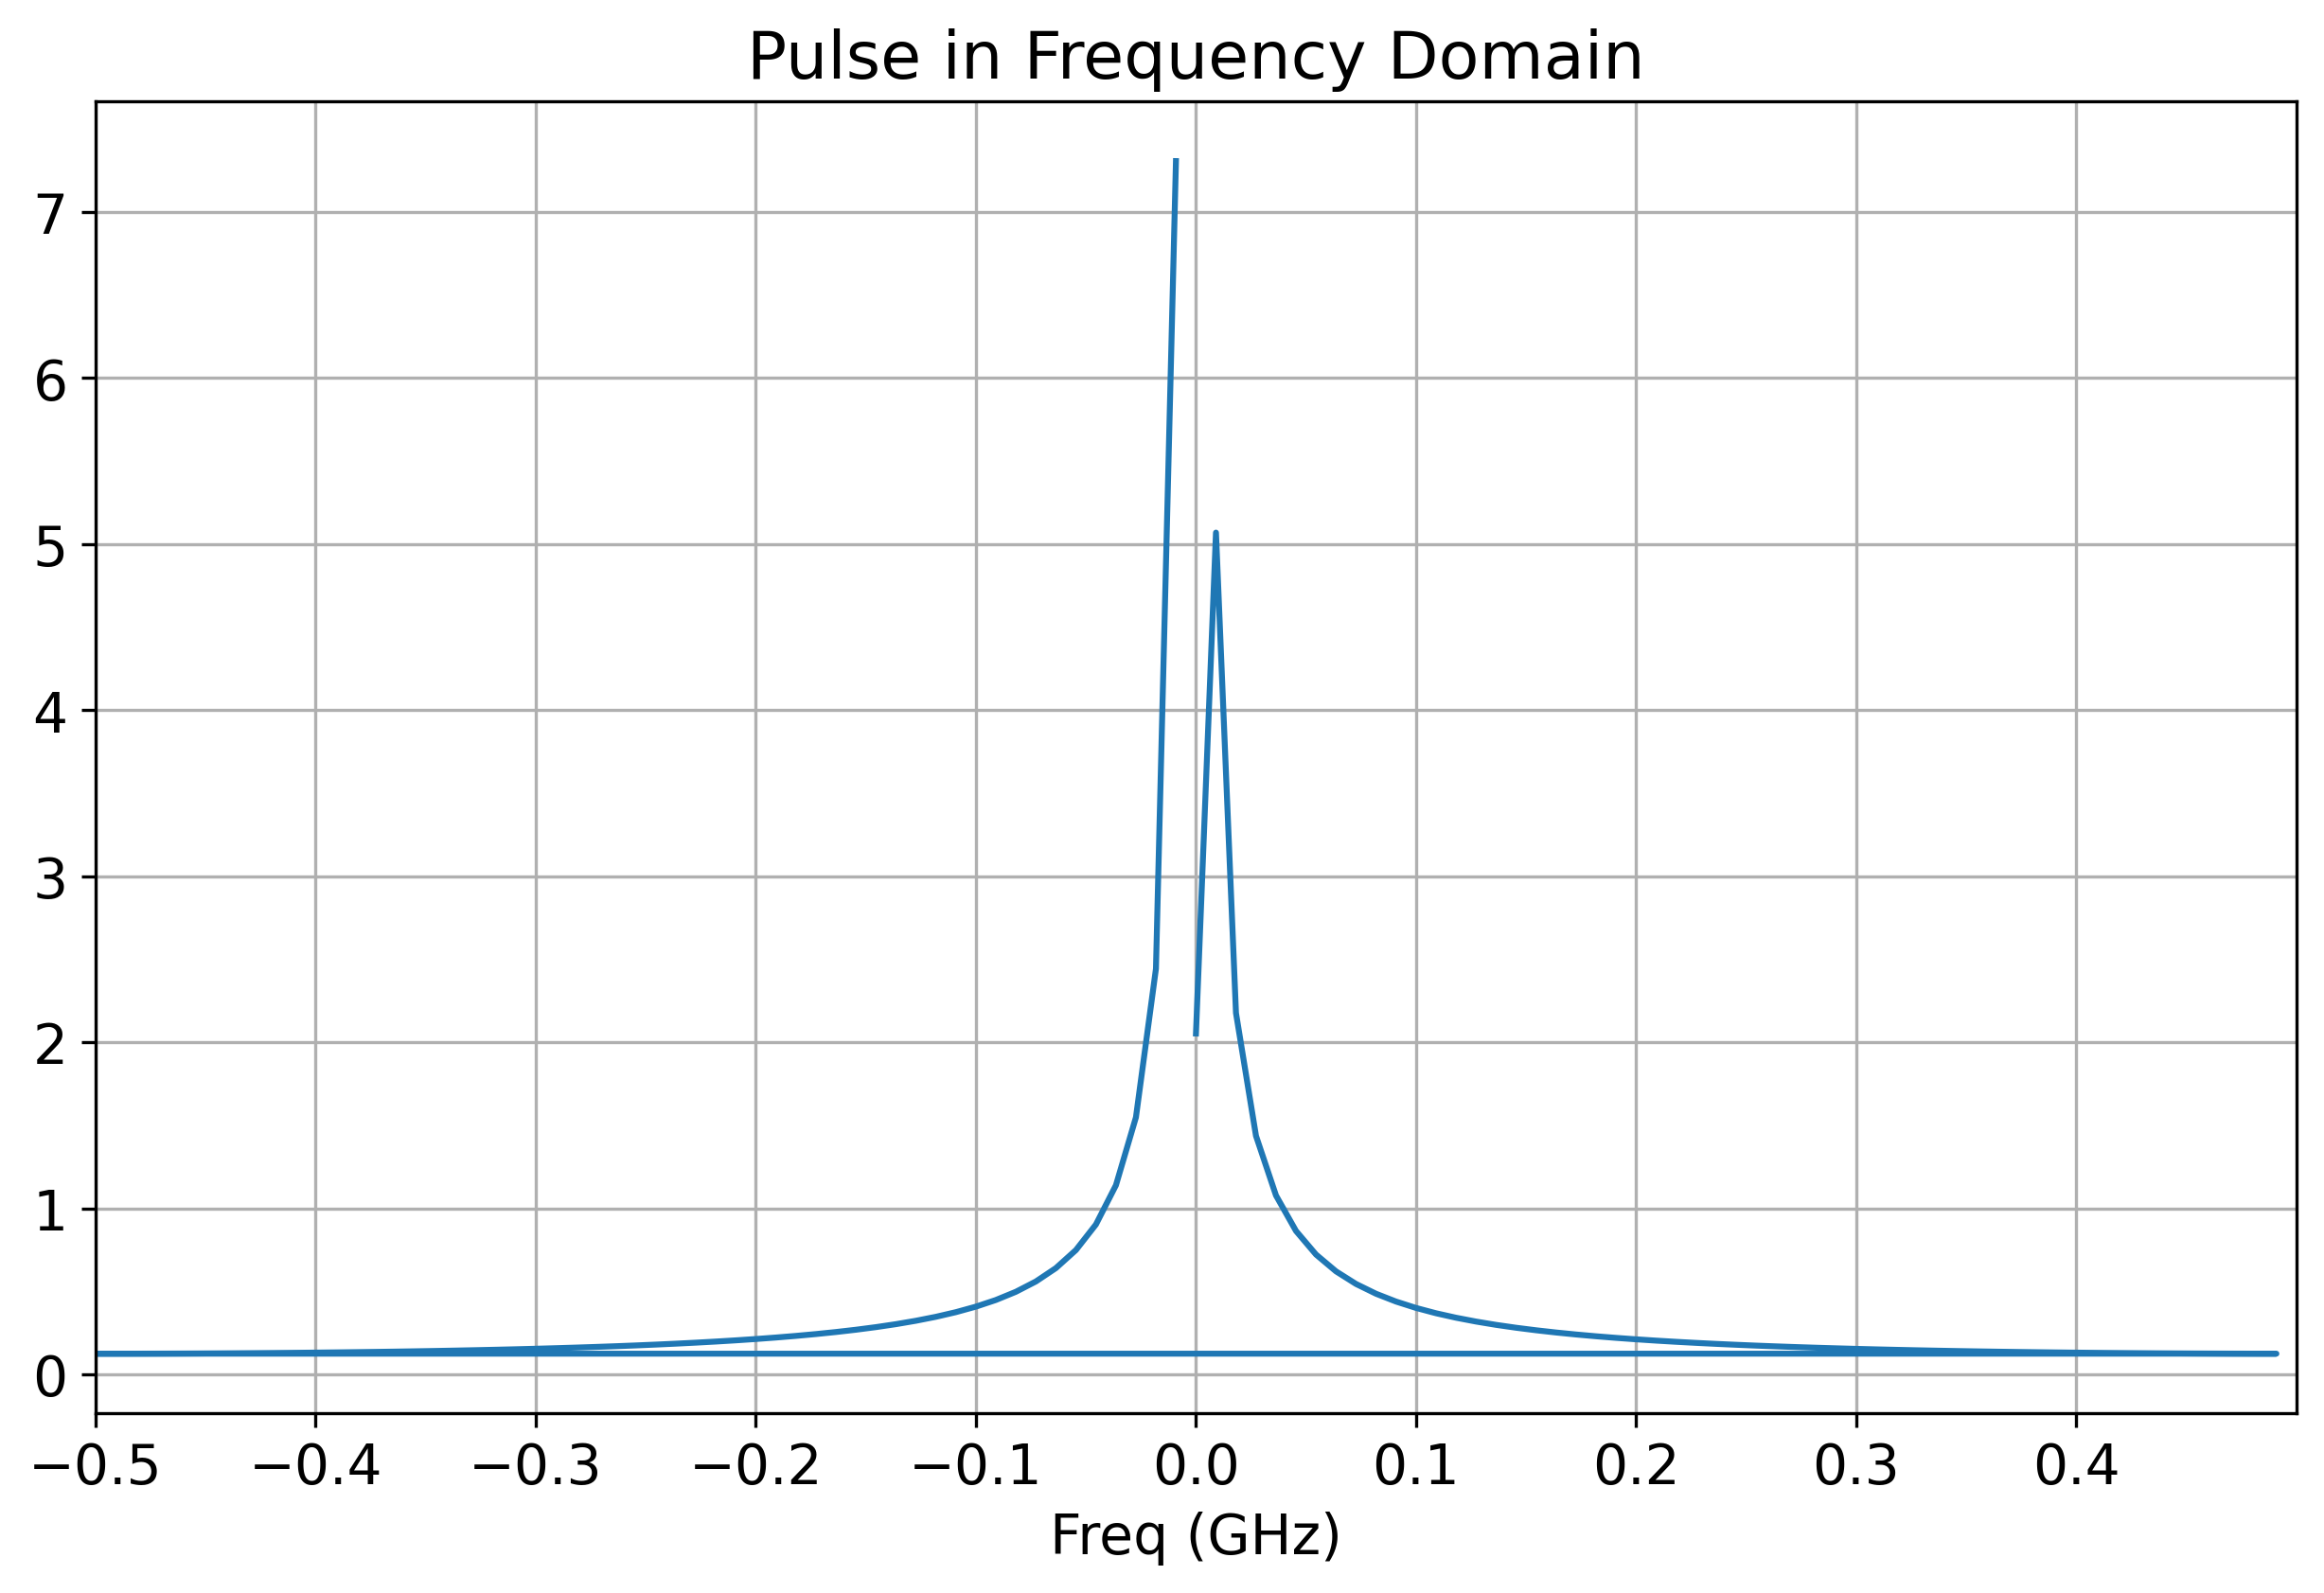

In [50]:
plt.figure(figsize = (10, 6), dpi = dpi)
z = np.array([0])
plt.plot(np.concatenate((z, times, times[-1]), axis=None), np.concatenate((z, asym_pulse_alpha.real, z), axis=None), label = 'Real')
plt.plot(np.concatenate((z, times, times[-1]), axis=None), np.concatenate((z, asym_pulse_alpha.imag, z), axis=None), label = 'Imaginary')
# plt.plot(times, asym_pulse_alpha.real, label = 'Real')
# plt.plot(times, asym_pulse_alpha.imag, label = 'Imaginary')

plt.xlabel("time (ns)")
plt.grid()
plt.legend()
plt.xticks(np.arange(times[0], times[-1]+1+10, 25))
# plt.xticks(np.arange(0, Total_gate_time//2+10, 10))
plt.title("Pulse in Time Domain")

FT = np.fft.fft(asym_pulse_alpha)
freq = np.fft.fftfreq(len(asym_pulse_alpha), d=timestep)

plt.figure(figsize = (10, 6), dpi = dpi)
plt.grid()

plt.plot(freq, np.abs(FT))

plt.xlabel("Freq (GHz)")
plt.title("Pulse in Frequency Domain")
plt.xticks(np.arange(-0.5, 0.5, 0.1))
plt.xlim(-0.5, 0.5)

print("PARAMETERS:")
print("wC:", wCg/2/np.pi, "* 2π GHz")
print("Chi:",(chi+wCg)/2/np.pi*(10**6), "* 2π kHz")
print("Detuning:", detuning/2/np.pi*(10**6), "* 2π kHz")
print("Total gate time:", Total_gate_time, "ns")
print("Pulse choice:", "" if is_square else ("Rough" if is_cut_tail_antisym else "Smooth"), "Square" if is_square else "Anti-symmetric Gaussian")
print("Max waveform amplitude:", "real =", np.abs(asym_pulse_alpha.real).max(), ", imag =", np.abs(asym_pulse_alpha.imag).max())

print(" ")


power = trapz(times, np.abs(asym_pulse_alpha))
max_voltage = np.max(np.abs(asym_pulse_alpha))
print("Power:", power)
print("Max voltage:", max_voltage)

### Pulse Module in time domain
(Can ignore, but works as a sanity check to see if your pulse is symmetric around the central point)

In [46]:
# plt.figure(figsize = (10, 6), dpi = 100)

# plt.plot(times, np.abs(asym_pulse_alpha), label = 'Abs')
# plt.xlabel("time (ns)")
# plt.legend()
# plt.xticks(np.arange(times[0], times[-1]+1+10, 25))
# plt.title("Pulse in Time Domain")

### Define Q and I drives

In [48]:
HdriveQ = 1j * tensor(qeye(2), destroy(N).dag() - destroy(N))
HdriveI = tensor(qeye(2), destroy(N).dag() + destroy(N))

### Choose Initial State

In [49]:
state_0 = superpos # |g> + |e> state
# state_0 = superpos*superpos.dag() # Density matrix
print("Initial state shape:", state_0.shape)
print("Initial state is a ket" if state_0.isket else "Initial state is a density matrix")

Initial state shape: (2000, 1)
Initial state is a ket


### Send the first anti-symmetric pulse!

In [33]:
res_asym1 = mesolve([H, 
                        [HdriveI, asym_pulse_alpha.real],
                        [HdriveQ, asym_pulse_alpha.imag]],
                        state_0,
                        times,
                        c_ops = c_ops,
                        e_ops = e_ops, 
                        progress_bar = True,
                        options = opts
                            )

# final_state = res_asym1.states[-1]

10.0%. Run time:   0.04s. Est. time left: 00:00:00:00
20.0%. Run time:   0.10s. Est. time left: 00:00:00:00
30.0%. Run time:   0.16s. Est. time left: 00:00:00:00
40.0%. Run time:   0.22s. Est. time left: 00:00:00:00
50.0%. Run time:   0.26s. Est. time left: 00:00:00:00
60.0%. Run time:   0.31s. Est. time left: 00:00:00:00


70.0%. Run time:   0.36s. Est. time left: 00:00:00:00
80.0%. Run time:   0.43s. Est. time left: 00:00:00:00
90.0%. Run time:   0.60s. Est. time left: 00:00:00:00
Total run time:   0.67s


### Plot the state after the first anti-symmetric pulse

Re:  -2.018724149738514 Im: 0.17781480669113206


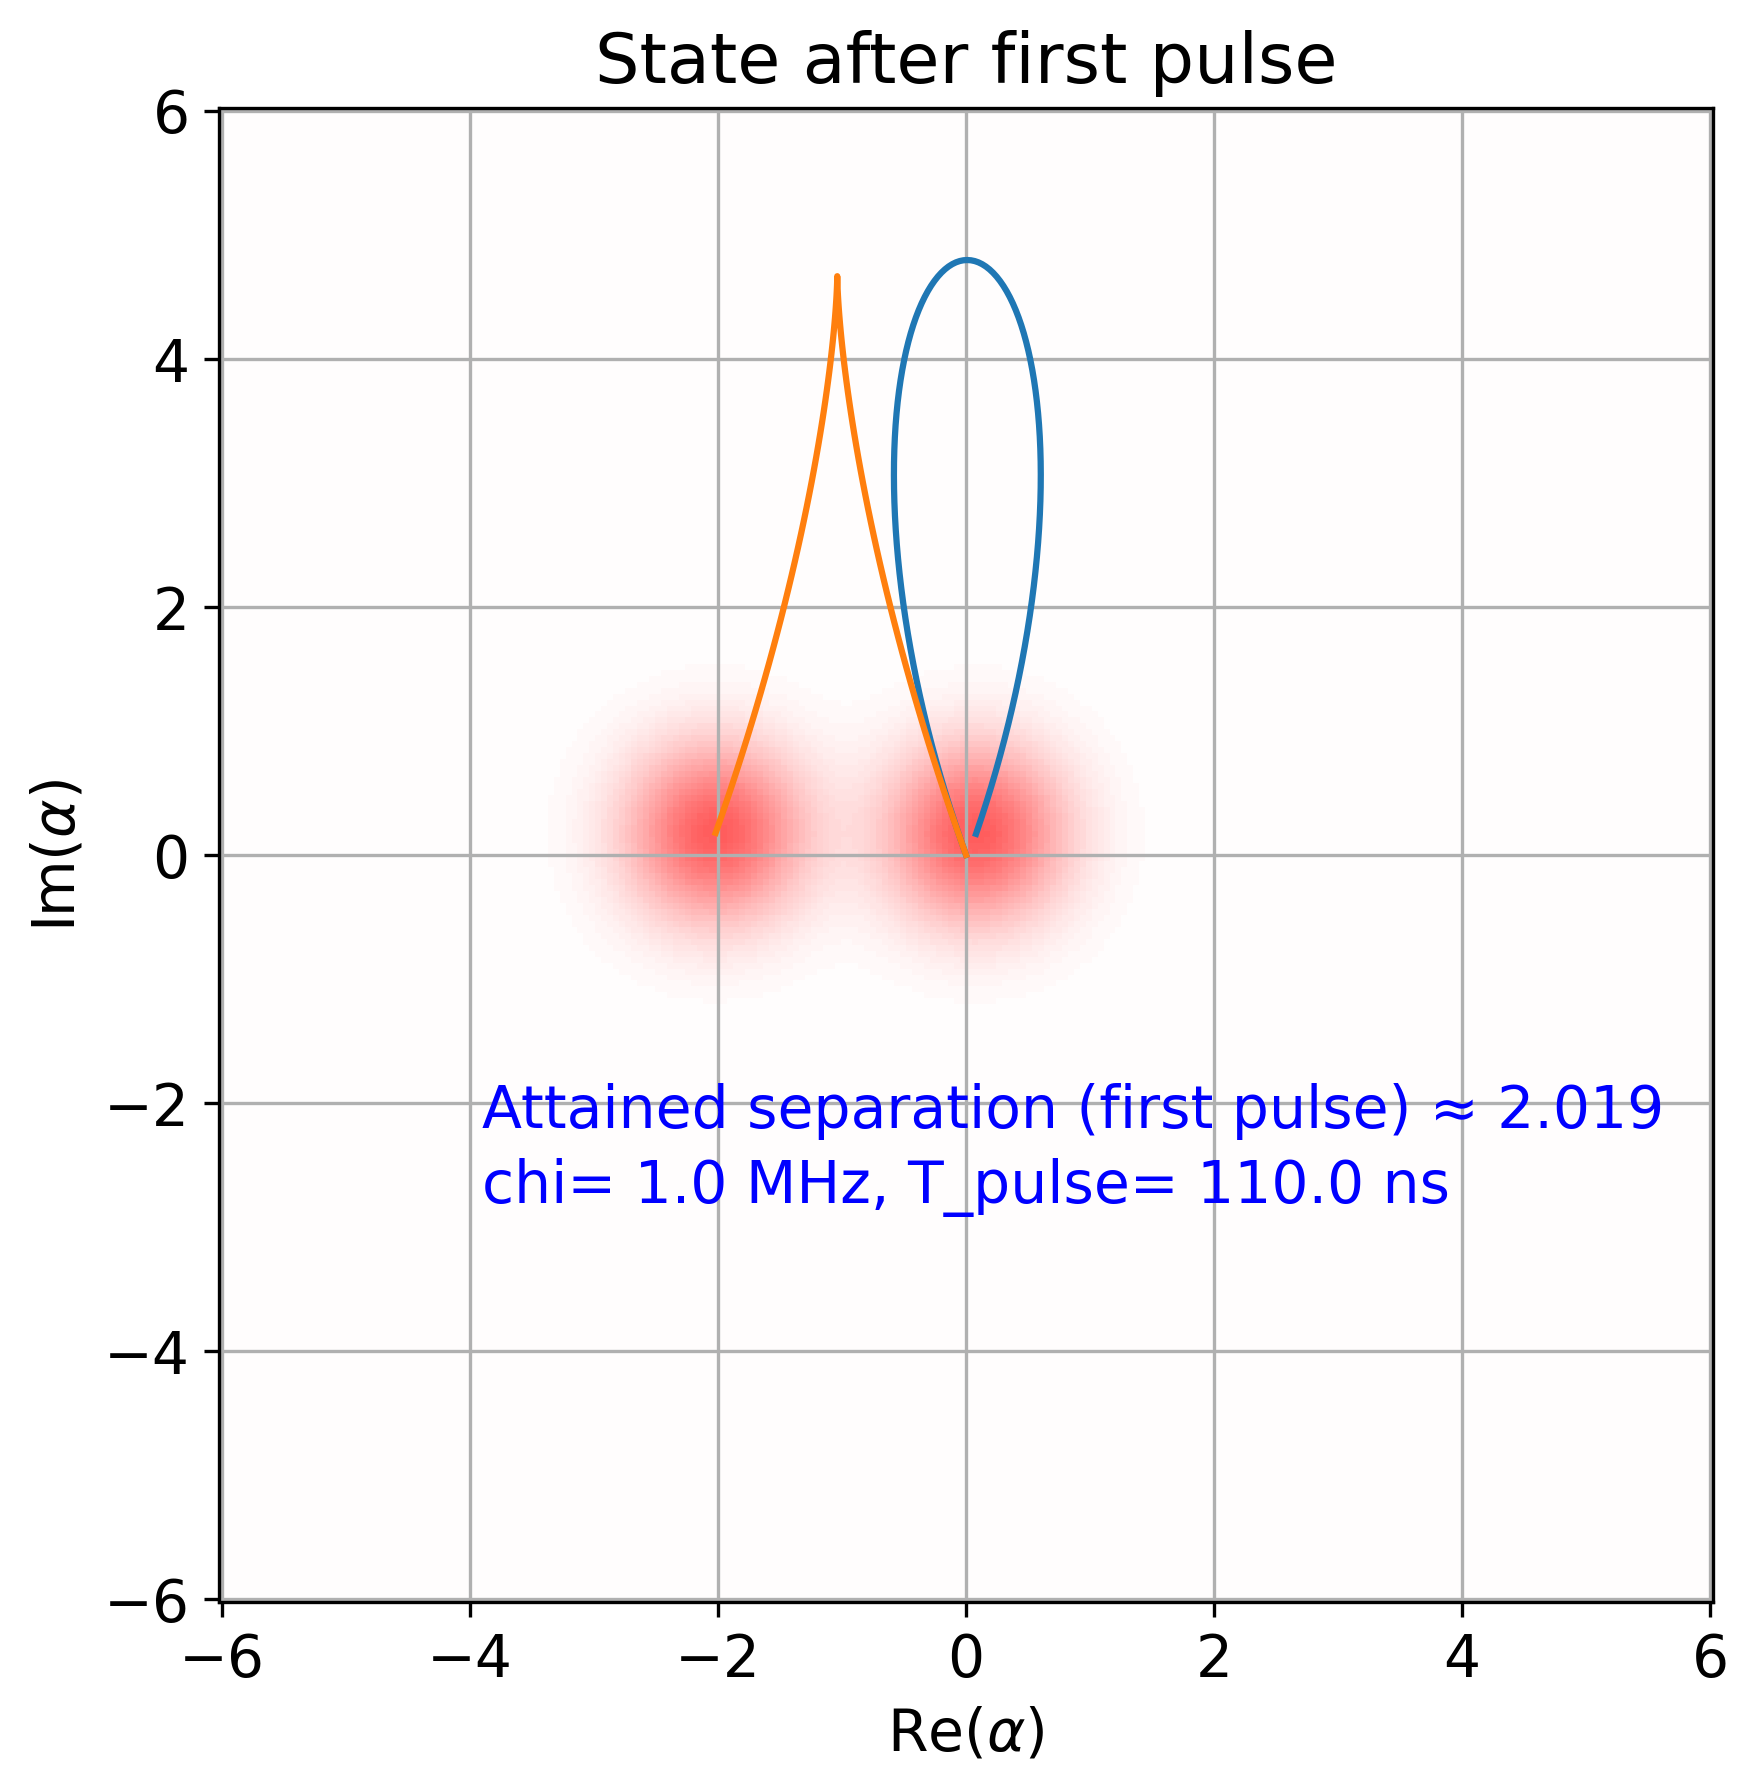

In [34]:
fig, axes = plt.subplots(1, 1, figsize=(10,6), dpi=dpi) # Create a 6-plot figure

plot_wigner_home(res_asym1.final_state, max_alpha=max_alpha, npts=npts, fig=fig, ax=axes)
plt.plot(res_asym1.expect[0].real,res_asym1.expect[0].imag) #qubit_e
plt.plot(res_asym1.expect[1].real,res_asym1.expect[1].imag) #qubit_g
print("Re: ", (res_asym1.expect[1].real)[-1], "Im:",((res_asym1.expect[1].imag)[-1]))

plt.title("State after first pulse")
num1 = round((chi+wCg)/2/np.pi*(10**3), 0)
plt.annotate(f"chi= {abs(num1)} MHz, T_pulse= {condisp_stop_time} ns", (-3.9,-2.8), c='blue')
num = round(-(res_asym1.expect[1].real)[-1], 3)
plt.annotate(f"Attained separation (first pulse) ≈ {num}", (-3.9,-2.2), c='blue')
plt.pause(0.5)

### Send $\pi$-pulse and second anti-symmetric pulse!

In [35]:
phase_corr = chi * (times[-1])*(-1) #*-1 try without the +1, might be a numerical problem for the offset in the centre
phase_corr = chi * (times[-1]+1)*(-1) #*-1 T_CNOD/2*chi

state1 = res_asym1.final_state

if state1.isket:
    state2 = Ry(np.pi) * state1 # Pi-pulse on qubit!
else:
    print("Consider using a ket instead of a density matrix to speed up the simulation!")
    state2 = Ry(np.pi) * state1 * Ry(np.pi).dag() # Pi-pulse on qubit!

res_asym2 = mesolve([H, 
                        [HdriveI, (-np.exp(1j*phase_corr)*asym_pulse_alpha).real], [HdriveQ, (-np.exp(1j*phase_corr)*asym_pulse_alpha).imag]], 
                        state2,
                        times,
                        c_ops = c_ops,
                        e_ops = e_ops,
                        progress_bar = True,
                        options = opts
                            )


10.0%. Run time:   0.06s. Est. time left: 00:00:00:00


20.0%. Run time:   0.13s. Est. time left: 00:00:00:00
30.0%. Run time:   0.19s. Est. time left: 00:00:00:00
40.0%. Run time:   0.24s. Est. time left: 00:00:00:00
50.0%. Run time:   0.30s. Est. time left: 00:00:00:00
60.0%. Run time:   0.48s. Est. time left: 00:00:00:00
70.0%. Run time:   0.55s. Est. time left: 00:00:00:00
80.0%. Run time:   0.63s. Est. time left: 00:00:00:00
90.0%. Run time:   0.70s. Est. time left: 00:00:00:00
Total run time:   0.76s


### Draw Arrow function

In [36]:
def add_arrow(line, position=None, direction='right', size=15, color=None, start_index=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    if start_index is None:
        start_ind = np.argmin(np.absolute(xdata - position))
        #print(start_ind)
    else: 
        start_ind = start_index
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->, head_width=0.4, head_length=0.5", color=color),
        size=size
    )

### Play second pulse!

Expectation value of g: (-1.6129207955542386+1.3448856193769718j) , Absolute value: 2.1000549568852476
Expectation value of e: (1.513960802960698-1.2629315223708026j) , Absolute value: 1.9715662157531597

 FINAL STATE SEPARATION: 4.071621172638407


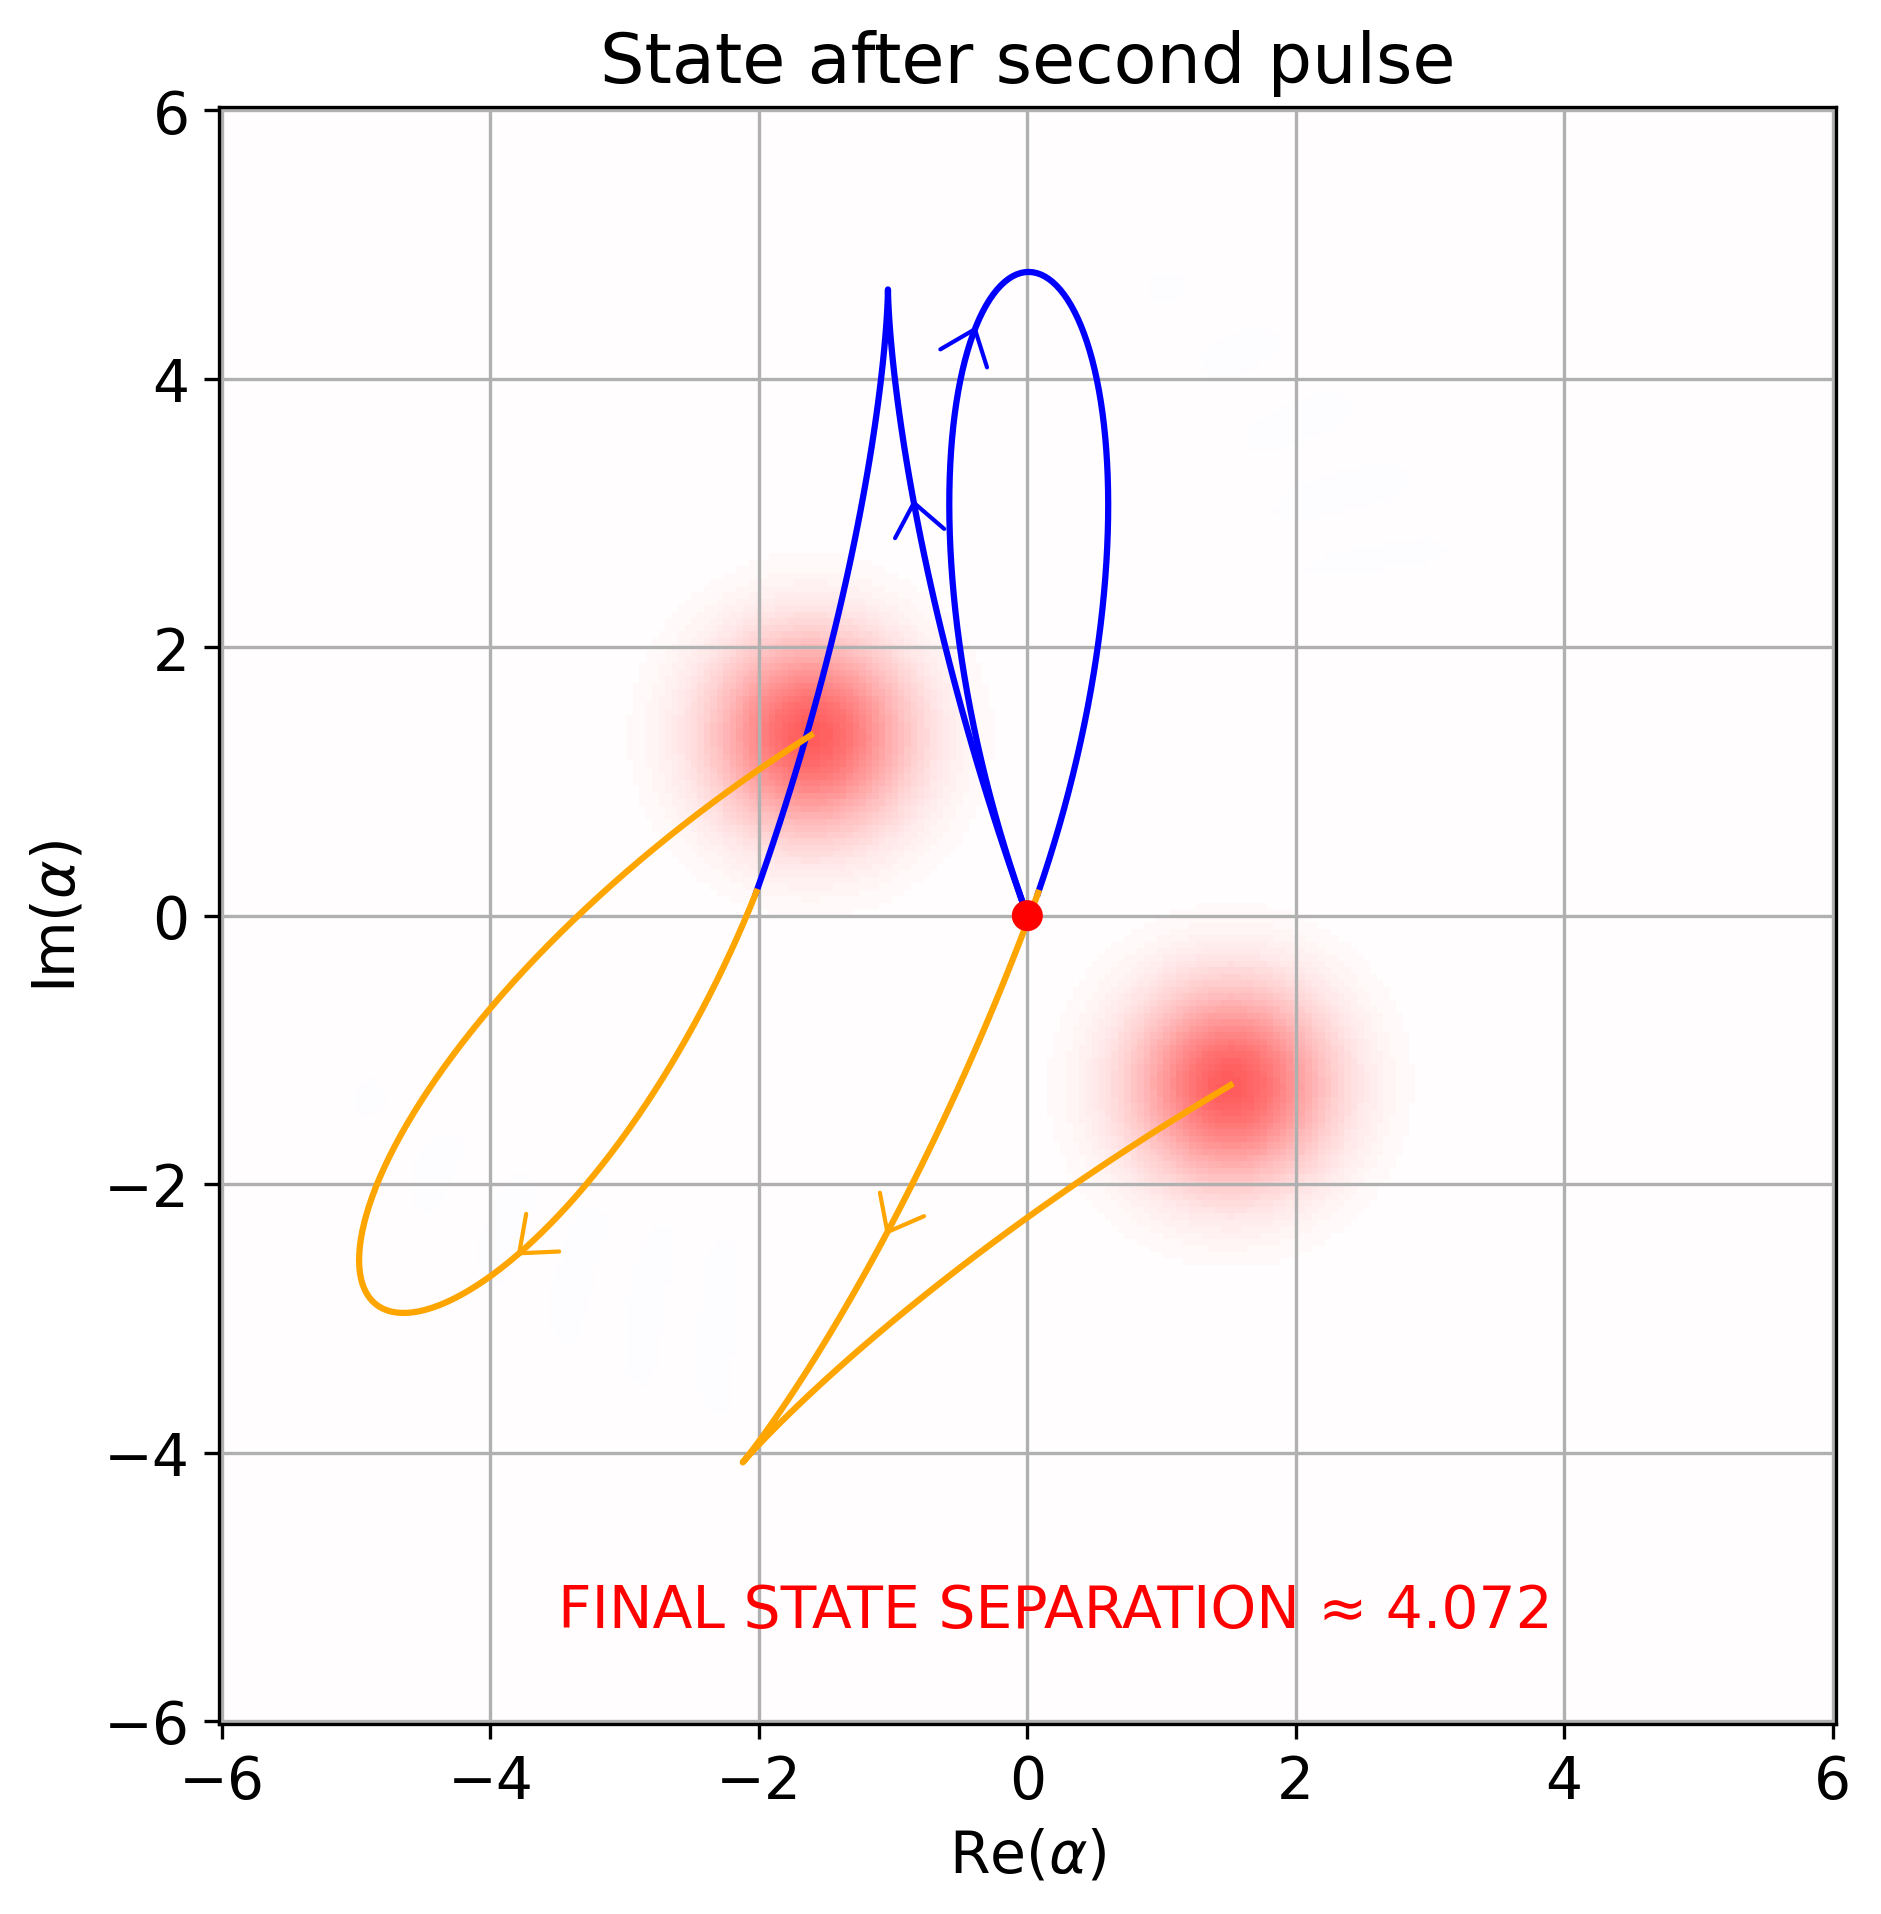

<Figure size 600x500 with 0 Axes>

In [37]:
# WITH ARROWS
fig = plt.figure(figsize=(7, 7), dpi=dpi)
axes = fig.subplots()

plot_wigner_home(res_asym2.final_state, npts=npts, max_alpha=max_alpha, cbar=False, ax=axes)

axes.set_title("State after second pulse")

circle = plt.Circle((0,0),0.1, fc='red',ec="red", zorder=10) #, label=r'$ \psi_0 $')
fig.gca().add_patch(circle)

a_g, a_e = 2*tensor(ket2dm(fock(2,0)), destroy(N)), 2*tensor(ket2dm(fock(2,1)), destroy(N))
proj_g_a = qt.tensor(basis(2,0)*basis(2,0).dag(), destroy(N))

line1 = axes.plot(res_asym1.expect[0].real,res_asym1.expect[0].imag, c='b', label = '1st pulse')[0] #qubit_e
add_arrow(line1, start_index=40)

line2 = axes.plot(res_asym1.expect[1].real,res_asym1.expect[1].imag, c='b')[0] #qubit_g
add_arrow(line2, start_index=25)

line3 = axes.plot(res_asym2.expect[0].real,res_asym2.expect[0].imag, c='orange', label = '2nd pulse')[0]
add_arrow(line3)

line4 = axes.plot(res_asym2.expect[1].real,res_asym2.expect[1].imag, c ='orange')[0]
add_arrow(line4)

print("Expectation value of g:", res_asym2.expect[0][-1], ", Absolute value:", np.abs(res_asym2.expect[0][-1]))
print("Expectation value of e:", res_asym2.expect[1][-1], ", Absolute value:", np.abs(res_asym2.expect[1][-1]))
separation = np.abs(res_asym2.expect[0][-1]) + np.abs(res_asym2.expect[1][-1])
axes.annotate(f"FINAL STATE SEPARATION ≈ {round(separation,3)}", (-3.5,-5.3), c='r')

print("\n FINAL STATE SEPARATION:", separation)

### Final state frame digital rotation (Global phase)

tetha degrees: -39.60000000000001


Text(0.5, 1.0, 'Rotated Final State')

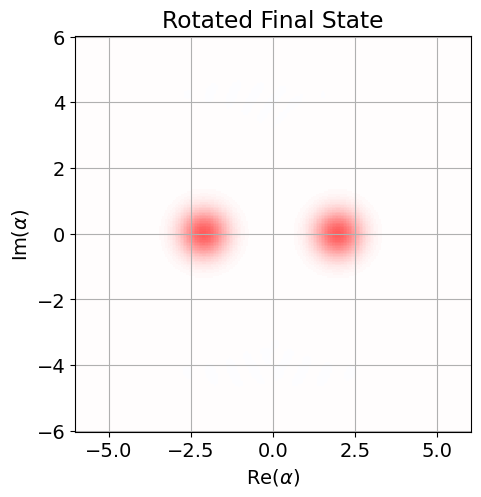

In [39]:
def rotate_mode(phi, rho):
    a = tensor(qeye(2), destroy(N))
    op = (-1j*phi*a.dag()*a).expm()
    if isket(rho):
        return op*(rho)
    return op*(rho)*op.dag()

theta = - Total_gate_time / 2 * chi
print("tetha degrees:", theta*180/np.pi)
rotated_final_state = rotate_mode(theta, res_asym2.final_state)
plot_wigner_home(rotated_final_state, npts=npts, max_alpha=max_alpha)
plt.title("Rotated Final State")

### Local Phase Estimation and State Fidelity

In [40]:
if rotated_final_state.isket:
    result_state = rotated_final_state
else:
    print("USE KET")
    result_state = None

if 0: 
    # No relative phase or choose arbitrary angle (default theta = 0)
    theta_list = [0]  
if 1:  
    # The final state has a relative phase!
    theta_list = np.linspace(41.50, 41.55, 5) # Choose the range and number of angles to check fidelity for

theoretical_list, fidelity_list = [], []

for theta in theta_list:
    rad = theta * np.pi/180
    theoretical = (tensor( fock(2,0), coherent(N, alpha/2) ) - np.exp(1j*rad) * tensor(fock(2,1), coherent(N, -alpha/2))).unit()
    fid = fidelity(theoretical, result_state)
    theoretical_list.append(theoretical)
    fidelity_list.append(fid)

max_fidelity = np.max(np.array(fidelity_list))
max_fidelity_index = np.argmax(np.array(fidelity_list))
theta_degrees = theta_list[max_fidelity_index]
rad = theta_degrees * np.pi/180
theo = (tensor( fock(2,0), coherent(N, alpha/2) ) - np.exp(1j*rad) * tensor(fock(2,1), coherent(N, -alpha/2))).unit()

print("Theta degrees (max fid):", theta_degrees, "deg")
print("Max achieved fidelity:", max_fidelity*100, "%")

Theta degrees (max fid): 41.5 deg
Max achieved fidelity: 99.72404362891639 %


Shapes: (2000, 1) (2000, 1)
Separation:  4.071621172638407
Fidelity:  99.72404362891639 %


Text(-5.0, 2.1, 'Fidelity ≈ 99.72404%')

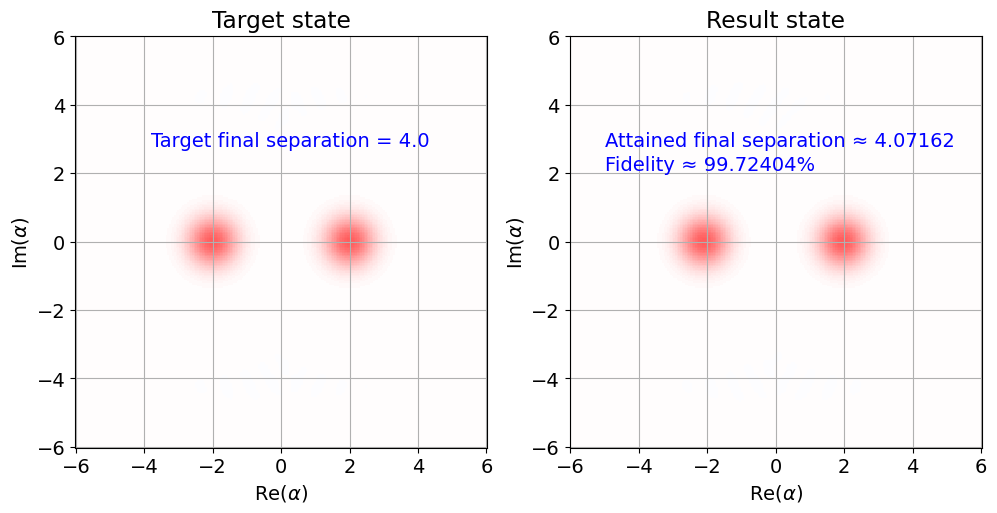

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

In [41]:
fig, axes = plt.subplots(1, 2) # Create a 2-plot figure

print("Shapes:", (theo).shape, result_state.shape)
print("Separation: ", separation)
print("Fidelity: ", max_fidelity*100, "%")

# Target state plot
plot_wigner_home(theo, npts=npts, max_alpha=max_alpha, ax=axes[0])  
axes[0].annotate(f"Target final separation = {alpha}", (-3.8,2.8), c='blue') 
axes[0].set_title("Target state")
      
# Result state plot
plot_wigner_home(result_state, npts=npts, max_alpha=max_alpha, ax=axes[1])
axes[1].set_title("Result state")
axes[1].annotate(f"Attained final separation ≈ {np.abs(round(-separation, 5))}", (-5.0,2.8), c='blue')
axes[1].annotate(f"Fidelity ≈ {round(max_fidelity*100,5)}%", (-5.0,2.1), c='blue')

### Expectation value of $ a^{\dag}a $

(220,)
Area CNOD trapz = 2940.421936693144
Area CNOD simpson = 2940.4255200642237


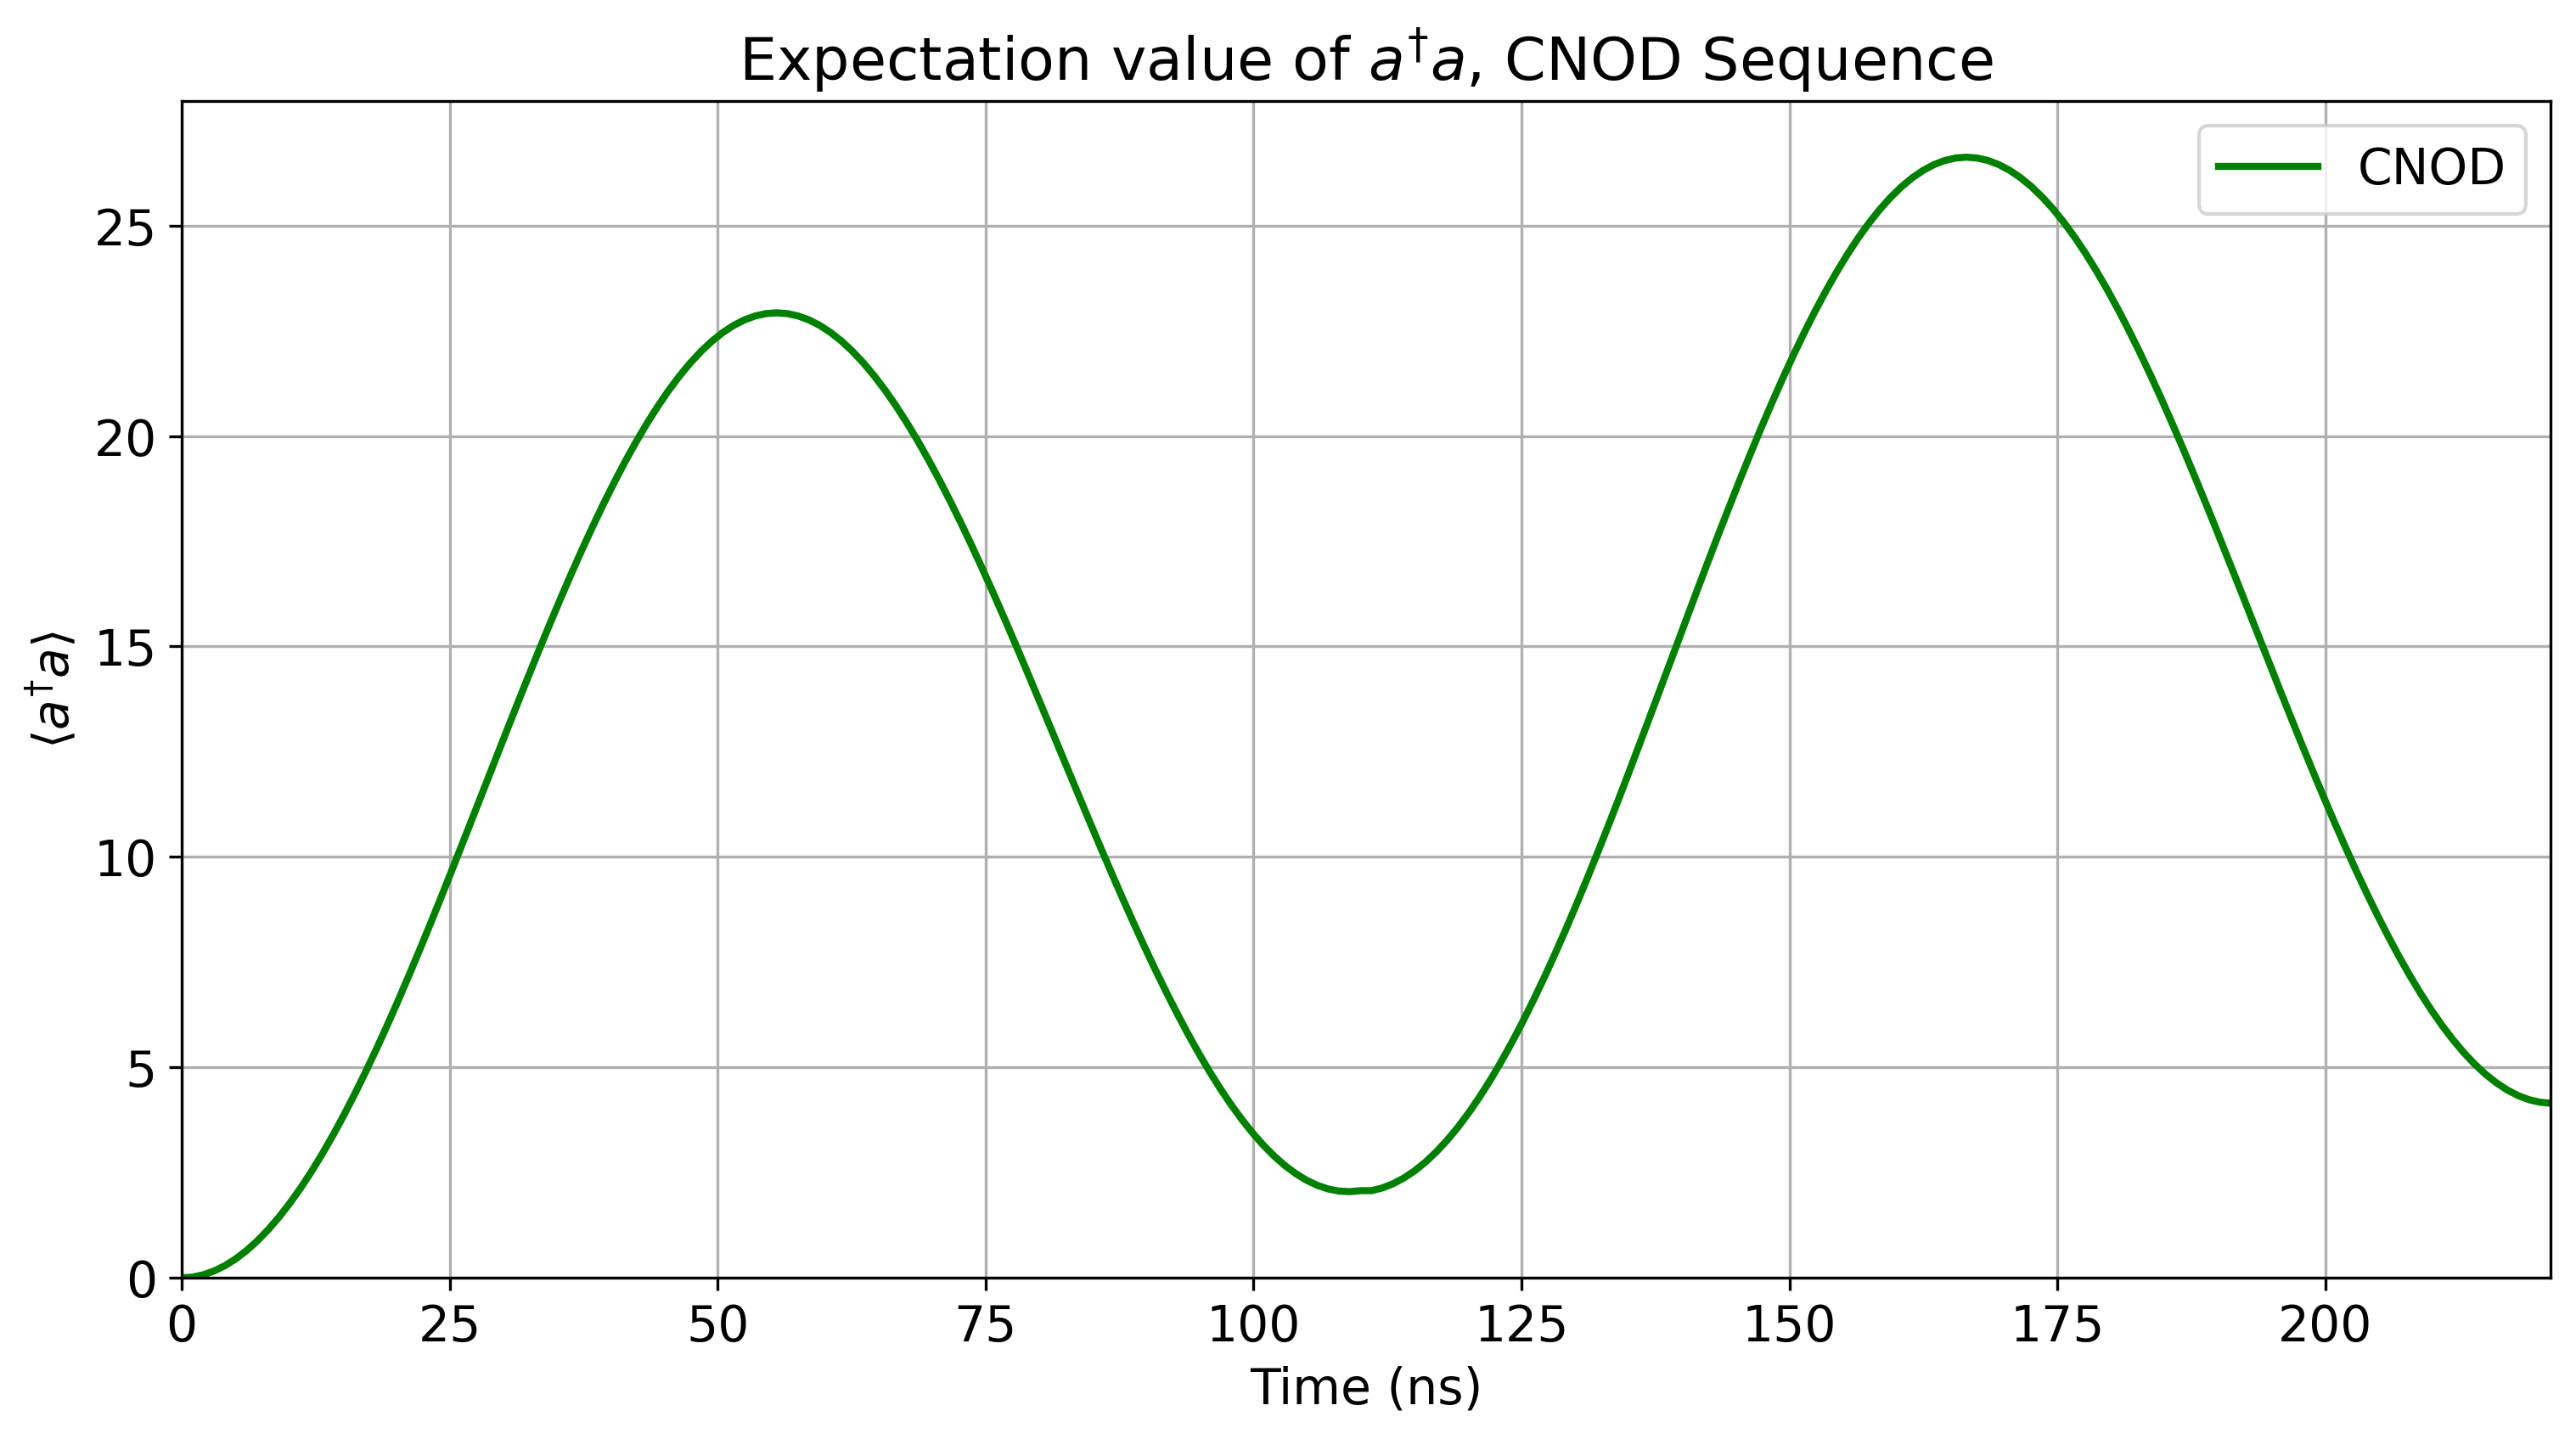

In [52]:
width = 2.0
# WITH ARROWS
fig = plt.figure(figsize=(12, 6), dpi = dpi)
axes = fig.subplots()
plt.grid()

times2 = [t + times[-1] + 1  for t in times]
times_list = np.concatenate((times, times2)) 

exp_cnod = np.concatenate((res_asym1.expect[2], res_asym2.expect[2]))

cnod = axes.plot(times_list, exp_cnod, c='g', label="CNOD", linewidth=width)[0]

axes.legend()
axes.set_xlabel("Time (ns)")
axes.set_ylabel(r"$\langle a^{\dag}a \rangle$")
axes.set_title(r"Expectation value of $a^{\dag}a$, CNOD Sequence")
axes.set_xlim(0,times_list[-1])
axes.set_ylim(0)

print(times_list.shape)

# Compute the area using the composite trapezoidal rule.
area = trapz(exp_cnod, times_list)
print("Area CNOD trapz =", area)

# Compute the area using the composite Simpson's rule.
area = simpson(exp_cnod, times_list)
print("Area CNOD simpson =", area)